In [165]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint
import pandas as pd

In [166]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Usando dados de [Hirokazu Takaya](https://lisphilar.github.io/covid19-sir/). Separando aqui para citação correta posteriormente.

In [167]:
# Importando dados
import covsirphy as cs

## Testes iniciais

(366, 3)


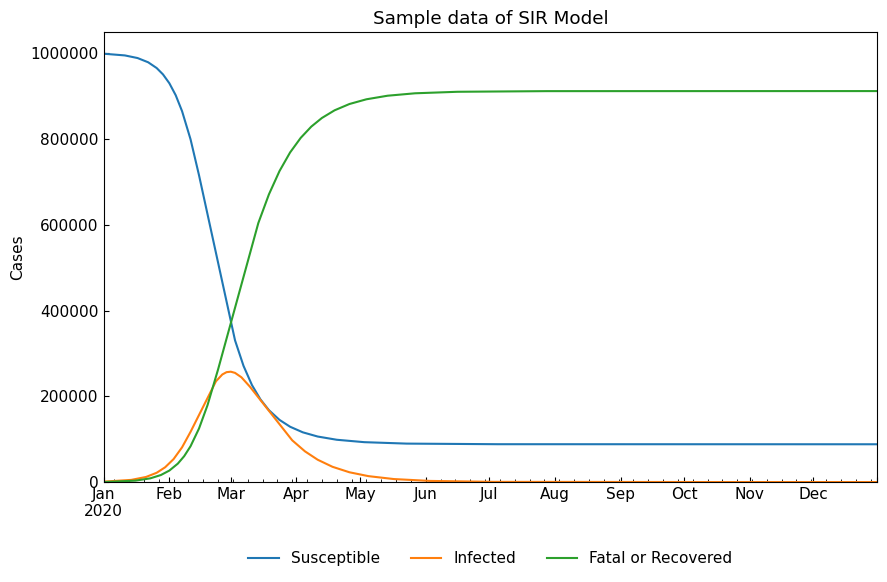

In [168]:
sir = cs.SIRModel.from_sample(date_range=("01Jan2020", "31Dec2020"), tau=1440)
sir_df = sir.solve()
print(sir_df.shape)
cs.line_plot(sir_df, title=f"Sample data of {sir}", y_integer=True)

## Preparando os dados

In [169]:
eng = cs.DataEngineer()
eng.download(databases=["covid19dh", "owid"])
eng.clean()
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272562 entries, 0 to 272561
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 272562 non-null  category      
 1   Province                             272562 non-null  category      
 2   City                                 272562 non-null  category      
 3   Date                                 272562 non-null  datetime64[ns]
 4   Cancel_events                        272562 non-null  Float64       
 5   Confirmed                            272562 non-null  Float64       
 6   Contact_tracing                      272562 non-null  Float64       
 7   Country                              272562 non-null  object        
 8   Fatal                                272562 non-null  Float64       
 9   Gatherings_restrictions              272562 non-null  Float64       
 

In [170]:
main_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
eng.transform()
eng_all = eng.all(variables=main_variables)

In [171]:
print(eng_all.shape)
eng_all

(272562, 8)


,ISO3,Province,City,Date,Susceptible,Infected,Recovered,Fatal
0,ABW,-,-,2020-01-22,105845.0,0.0,0.0,0.0
1,ABW,-,-,2020-01-23,105845.0,0.0,0.0,0.0
2,ABW,-,-,2020-01-24,105845.0,0.0,0.0,0.0
3,ABW,-,-,2020-01-25,105845.0,0.0,0.0,0.0
4,ABW,-,-,2020-01-26,105845.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
272557,ZWE,-,-,2023-03-05,14174891.0,175465.0,82994.0,5668.0
272558,ZWE,-,-,2023-03-06,14174891.0,175465.0,82994.0,5668.0
272559,ZWE,-,-,2023-03-07,14174891.0,175465.0,82994.0,5668.0
272560,ZWE,-,-,2023-03-08,14174742.0,175611.0,82994.0,5671.0


In [172]:
countries_iso = eng_all['ISO3'].unique()

In [173]:
# pick all countries with more than 1000 rows
countries = [country for country in countries_iso if eng_all[eng_all['ISO3'] == country].shape[0] > 1000]
# limit to 100 countries
countries = countries[:100]
print(len(countries))

100


In [174]:
# from all countries, get row where Date == '2020-07-25'
countries_df = eng_all[eng_all['ISO3'].isin(countries)]
countries_df = countries_df[countries_df['Date'] == '2020-07-25']
countries_df

,ISO3,Province,City,Date,Susceptible,Infected,Recovered,Fatal
185,ABW,-,-,2020-07-25,105726.0,14.0,102.0,3.0
1416,AFG,-,-,2020-07-25,37136264.0,10079.0,24793.0,1250.0
2640,AGO,-,-,2020-07-25,30808846.0,635.0,242.0,39.0
3864,AIA,-,-,2020-07-25,18087.0,0.0,3.0,0.0
5054,ALB,-,-,2020-07-25,2861739.0,1866.0,2637.0,134.0
...,...,...,...,...,...,...,...,...
116715,ISL,-,-,2020-07-25,350878.0,10.0,1823.0,10.0
117877,ISR,-,-,2020-07-25,8821384.0,24754.0,36168.0,494.0
119046,ITA,-,-,2020-07-25,60175896.0,12442.0,198320.0,35102.0
120277,JAM,-,-,2020-07-25,2934018.0,116.0,711.0,10.0


## Montando o modelo

In [175]:
x0 = np.empty((100, 3))
x0[:, 0] = countries_df['Susceptible'].values
x0[:, 1] = countries_df['Infected'].values
x0[:, 2] = countries_df['Recovered'].values
# print primeiras 5 linhas
x0[:5]

array([[1.0572600e+05, 1.4000000e+01, 1.0200000e+02],
       [3.7136264e+07, 1.0079000e+04, 2.4793000e+04],
       [3.0808846e+07, 6.3500000e+02, 2.4200000e+02],
       [1.8087000e+04, 0.0000000e+00, 3.0000000e+00],
       [2.8617390e+06, 1.8660000e+03, 2.6370000e+03]])

SIR sem fator de normalização.
$$\ \dot{S} = - \beta I S$$
$$\ \dot{I} = \beta I S - \gamma I$$
$$\ \dot{R} = - \gamma I S$$

In [176]:
beta = 0.2; gamma = 0.075
def sir_deriv(s_i_r, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

In [177]:
# Preparando o treinamento
# A ideia é treinar 600 dias
# O dia inicial é 2020-07-25
dates = pd.date_range(start='2020-07-25', periods=601, freq='D')
t = np.array([(date - dates[0]).days for date in dates])
print(t.shape)
t[:10]

(601,)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [178]:
nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)

In [179]:
# Resolvendo o sistema de equações diferenciais
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])

/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8158137592760D+02   r2 =  0.8793158919658D-08
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6920861527317D+02   r2 =  0.8650135363841D-08


In [180]:
for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

In [181]:
print(nn_input)
print(nn_output)
# Parece normal, com o sir establiziando no final (comportamento normal dele mesmo)

[[ 1.05726000e+05  1.40000000e+01  1.02000000e+02]
 [ 9.94467565e-11  9.81947375e+04  7.64726253e+03]
 [ 3.31175011e-09  9.10995286e+04  1.47424714e+04]
 ...
 [-4.43278167e-10 -3.30877718e-11  9.95600000e+06]
 [-4.43278167e-10 -3.33141488e-11  9.95600000e+06]
 [-4.43278167e-10 -3.35003016e-11  9.95600000e+06]]
[[ 9.94467565e-11  9.81947375e+04  7.64726253e+03]
 [ 3.31175011e-09  9.10995286e+04  1.47424714e+04]
 [-6.42314167e-09  8.45169946e+04  2.13250054e+04]
 ...
 [-4.43278167e-10 -3.33141488e-11  9.95600000e+06]
 [-4.43278167e-10 -3.35003016e-11  9.95600000e+06]
 [-4.43278167e-10 -3.36462301e-11  9.95600000e+06]]


In [182]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')

TODO: Aplicar alguma técnica de normalização.

In [183]:
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 120118297893367468523520.0000
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 120118297893367468523520.0000
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 120118297893367468523520.0000
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 120118297893367468523520.0000
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 120118297893367468523520.0000
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 120118297893367468523520.0000
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 120118297893367468523520.0000
Epoch 8/30
1875/1875 [==============================] - 7s 4ms/step - loss: 120118297893367468523520.0000
Epoch 9/30
  16/1875 [..............................] - ETA: 6s - loss: 5127382960701440.0000 

KeyboardInterrupt: 